In [115]:
%matplotlib inline
import matplotlib.pyplot as plt
from ttvfast import ttvfast
from ttvfast.models import Planet 
from astropy.constants import M_sun, M_earth
import numpy as np
import astropy.units as u 

median_params = np.load('median_ttv_params.npy')
maxlnprob_params = np.load('maxlnprob_ttv_params.npy')

observed_timing = np.loadtxt("../libra/data/ttvs/timing_k62_Kep_HST.txt", delimiter=',')
timing_e = observed_timing[observed_timing[:, 0] == 1][:, -3:]
timing_f = observed_timing[observed_timing[:, 0] == 2][:, -3:]

timing_e[:, 1] += 2450000
timing_f[:, 1] += 2450000

epochs_e, times_e, errs_e = timing_e.T
epochs_f, times_f, errs_f = timing_f.T

mass_e_init = 4.45356410231 * float(M_earth/M_sun) # Forecaster + Gaia (Berger 2018, Chen+ 2017)
mass_f_init = 3.33116078749 * float(M_earth/M_sun) # Forecaster + Gaia (Berger 2018, Chen+ 2017)

Maximum likelihood parameters: 

In [116]:
mass_e, mass_f, period_e, period_f, lam_e, lam_f, ecc_e, ecc_f, w_e, w_f = maxlnprob_params

e = Planet(mass=mass_e_init, period=period_e, eccentricity=ecc_e, inclination=89.98, 
           longnode=90, argument=w_e, mean_anomaly=lam_e)
f = Planet(mass=mass_f_init, period=period_f, eccentricity=ecc_f, inclination=89.90, 
           longnode=90, argument=w_f, mean_anomaly=lam_f)
result = ttvfast(planets=[e, f], stellar_mass=0.69, time=times_e.min()-0.01, dt=period_e/50, total=times_e.min()+10000)
planet_ind, epoch, times, rsky, vsky = [np.array(i) for i in result['positions']]
ignore_condition = (times != -2)
planet_ind, epoch, times, rsky, vsky = [i[ignore_condition] for i in [planet_ind, epoch, times, rsky, vsky]]

indices_e = (planet_ind == 0) #& np.in1d(epoch, epochs_e)
indices_f = (planet_ind == 1) #& np.in1d(epoch, epochs_f + 1)
maxln_epoch_e = epoch[indices_e]
maxln_epoch_f = epoch[indices_f]
maxln_model_times_e = times[indices_e]
maxln_model_times_f = times[indices_f]

Median of posterior samples: 

In [117]:
mass_e, mass_f, period_e, period_f, lam_e, lam_f, ecc_e, ecc_f, w_e, w_f = median_params

e = Planet(mass=mass_e_init, period=period_e, eccentricity=ecc_e, inclination=89.98, 
           longnode=90, argument=w_e, mean_anomaly=lam_e)
f = Planet(mass=mass_f_init, period=period_f, eccentricity=ecc_f, inclination=89.90, 
           longnode=90, argument=w_f, mean_anomaly=lam_f)
result = ttvfast(planets=[e, f], stellar_mass=0.69, time=times_e.min()-0.01, dt=period_e/50, total=times_e.min()+10000)
planet_ind, epoch, times, rsky, vsky = [np.array(i) for i in result['positions']]
ignore_condition = (times != -2)
planet_ind, epoch, times, rsky, vsky = [i[ignore_condition] for i in [planet_ind, epoch, times, rsky, vsky]]

indices_e = (planet_ind == 0) #& np.in1d(epoch, epochs_e)
indices_f = (planet_ind == 1) #& np.in1d(epoch, epochs_f + 1)
median_epoch_e = epoch[indices_e]
median_epoch_f = epoch[indices_f]
median_model_times_e = times[indices_e]
median_model_times_f = times[indices_f]

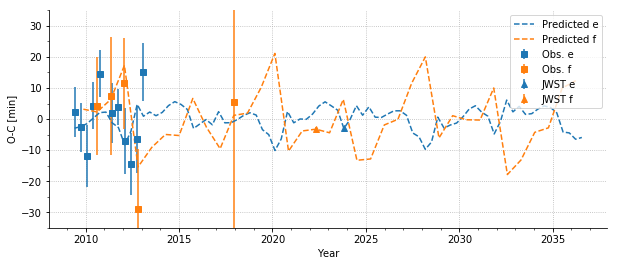

In [170]:
linear_ephem_e = np.polyval(np.polyfit(epochs_e, times_e, 1), epochs_e)
linear_ephem_f = np.polyval(np.polyfit(epochs_f, times_f, 1), epochs_f)
plt.figure(figsize=(10, 4))
plt.errorbar(Time(times_e, format='jd').decimalyear, 24*60*(times_e - linear_ephem_e), 24*60*errs_e, fmt='s', label="Obs. e")
plt.errorbar(Time(times_f, format='jd').decimalyear, 24*60*(times_f - linear_ephem_f), 24*60*errs_f, fmt='s', label="Obs. f")


median_linear_ephem_e = np.polyval(np.polyfit(median_epoch_e, median_model_times_e, 1), median_epoch_e)
median_linear_ephem_f = np.polyval(np.polyfit(median_epoch_f, median_model_times_f, 1), median_epoch_f)

maxln_linear_ephem_e = np.polyval(np.polyfit(maxln_epoch_e, maxln_model_times_e, 1), maxln_epoch_e)
maxln_linear_ephem_f = np.polyval(np.polyfit(maxln_epoch_f, maxln_model_times_f, 1), maxln_epoch_f)

# plt.plot(median_model_times_e, 24*60*(median_model_times_e - median_linear_ephem_e), ms=1, label='med')
# plt.plot(median_model_times_f, 24*60*(median_model_times_f - median_linear_ephem_f), ms=1, label='med')
plt.plot(Time(maxln_model_times_e, format='jd').decimalyear, 24*60*(maxln_model_times_e - maxln_linear_ephem_e), 
              ms=1, ls='--', label='Predicted e', color='C0')
plt.plot(Time(maxln_model_times_f, format='jd').decimalyear, 24*60*(maxln_model_times_f - maxln_linear_ephem_f),
              ms=1, ls='--', label='Predicted f', color='C1')
np.savetxt('../libra/data/ttvs/model_62e.txt', maxln_model_times_e)
np.savetxt('../libra/data/ttvs/model_62f.txt', maxln_model_times_f)

np.random.seed(1984)

random_e = np.random.choice(maxln_model_times_e[(Time(maxln_model_times_e, format='jd').decimalyear > 2019.5) & (Time(maxln_model_times_e, format='jd').decimalyear < 2019.5 + 5)])
random_f = np.random.choice(maxln_model_times_f[(Time(maxln_model_times_f, format='jd').decimalyear > 2019.5) & (Time(maxln_model_times_f, format='jd').decimalyear < 2019.5 + 5) ])

yerr_e = (25*u.s).to(u.min).value
yerr_f = (41*u.s).to(u.min).value

ind_e = np.argmin(np.abs(random_e - maxln_model_times_e))
ind_f = np.argmin(np.abs(random_f - maxln_model_times_f))

y_e = 24*60*(maxln_model_times_e - maxln_linear_ephem_e)[ind_e]
y_f = 24*60*(maxln_model_times_f - maxln_linear_ephem_f)[ind_f]

# for t, y, yerr, c in zip([random_e, random_f], [y_e, y_f], [yerr_e, yerr_f], ['C0', 'C1']):
#     plt.axvline(Time(t, format='jd').decimalyear, ls=':', color=c)
plt.errorbar(Time(random_e, format='jd').decimalyear, y_e, yerr_e, color='C0', fmt='^', label='JWST e')
plt.errorbar(Time(random_f, format='jd').decimalyear, y_f, yerr_f, color='C1', fmt='^', label='JWST f')

for s in ['right', 'top']:
    plt.gca().spines[s].set_visible(False)
plt.xlabel('Year')
plt.grid(ls=":")
plt.ylim([-35, 35])
plt.ylabel('O-C [min]')

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

minorLocator = MultipleLocator(1)

minorLocator5 = MultipleLocator(5)

plt.gca().xaxis.set_minor_locator(minorLocator)

plt.gca().yaxis.set_minor_locator(minorLocator5)
plt.legend()

plt.savefig('ttvs_predicted.pdf', bbox_inches='tight')
plt.show()

In [157]:
random_e, random_f

(2460246.0159507664, 2459699.4756669635)

Text(0,0.5,'O-C [min]')

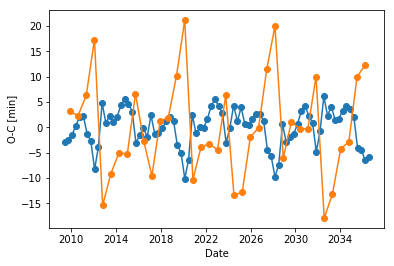

In [120]:
plt.plot_date(Time(maxln_model_times_e, format='jd').plot_date, 24*60*(maxln_model_times_e - maxln_linear_ephem_e), ls='-')#
plt.plot_date(Time(maxln_model_times_f, format='jd').plot_date, 24*60*(maxln_model_times_f - maxln_linear_ephem_f), ls='-')

plt.xlabel('Date')
plt.ylabel('O-C [min]')

In [172]:
all_transits_e = maxln_model_times_e[(Time(maxln_model_times_e, format='jd').decimalyear > 2019.5) & (Time(maxln_model_times_e, format='jd').decimalyear < 2019.5 + 5)]
all_transits_f = maxln_model_times_f[(Time(maxln_model_times_f, format='jd').decimalyear > 2019.5) & (Time(maxln_model_times_f, format='jd').decimalyear < 2019.5 + 5)]

np.save('all_transits_e.npy', all_transits_e)
np.save('all_transits_f.npy', all_transits_f)

In [175]:
len(all_transits_e), len(all_transits_f)

(15, 6)